事前計算されたチャープ率を使用: 0.0025
最終的な基準チャープ波形を生成中...
生成されたドメイン数: 4000
比較用の単一周波数（一定周期）波形を生成中...

焼きなまし法（ドメイン区間反転版）による最適化中...
  Iteration 1000/10000: Cost = 8.67e+06, Temp = 36.77
  Iteration 2000/10000: Cost = 8.426e+06, Temp = 13.52
  Iteration 3000/10000: Cost = 6.856e+06, Temp = 4.971
  Iteration 4000/10000: Cost = 6.367e+06, Temp = 1.828
  Iteration 5000/10000: Cost = 5.187e+06, Temp = 0.6721
  Iteration 6000/10000: Cost = 5.062e+06, Temp = 0.2471
  Iteration 7000/10000: Cost = 4.959e+06, Temp = 0.09087
  Iteration 8000/10000: Cost = 4.692e+06, Temp = 0.03341
  Iteration 9000/10000: Cost = 4.616e+06, Temp = 0.01229
  Iteration 10000/10000: Cost = 4.483e+06, Temp = 0.004517
最適化完了。


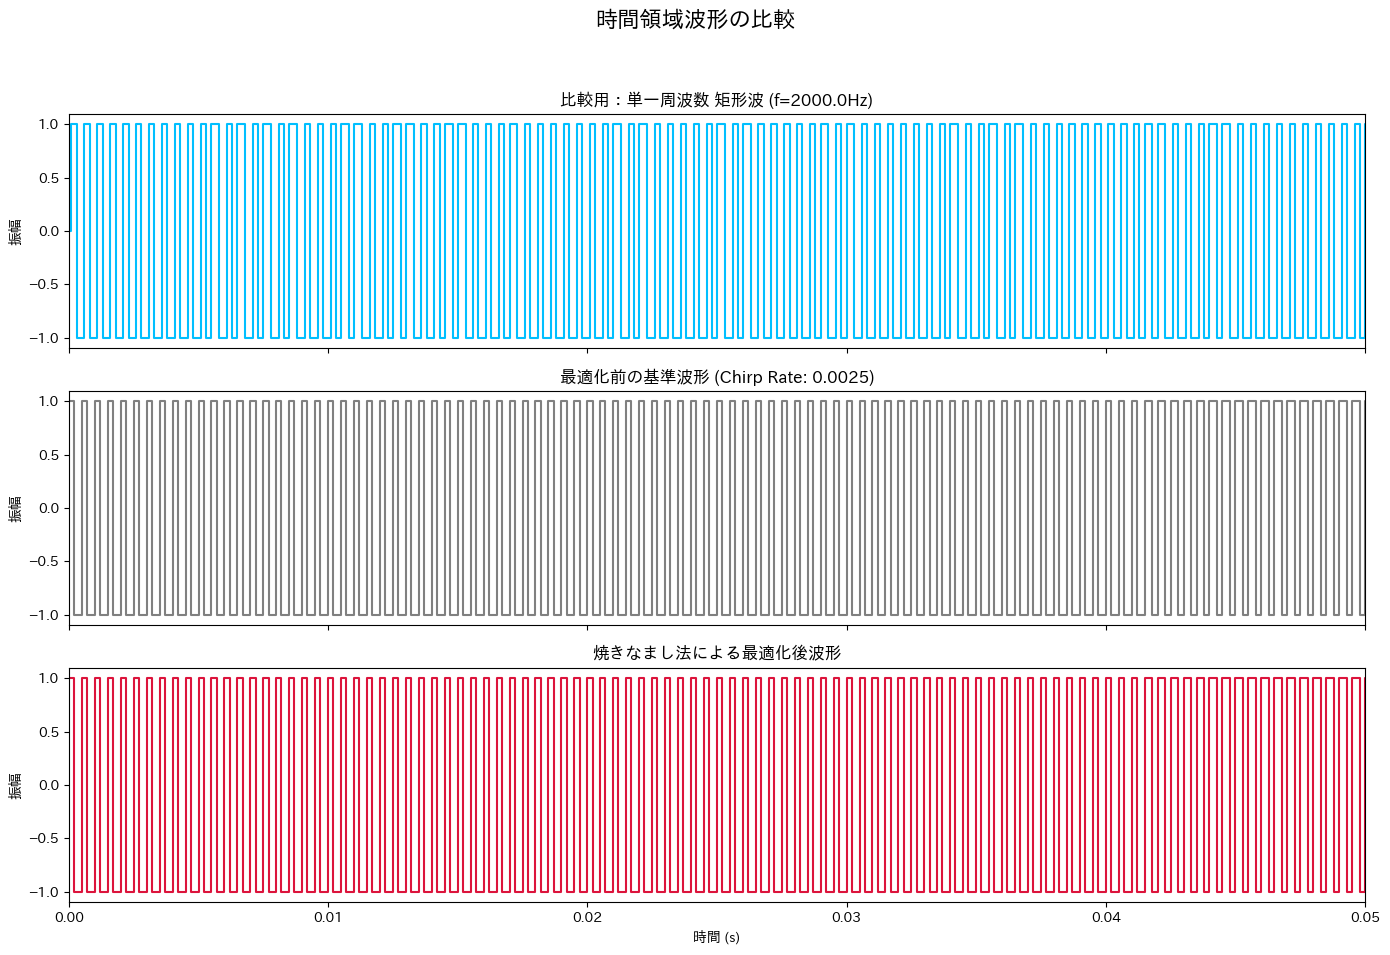

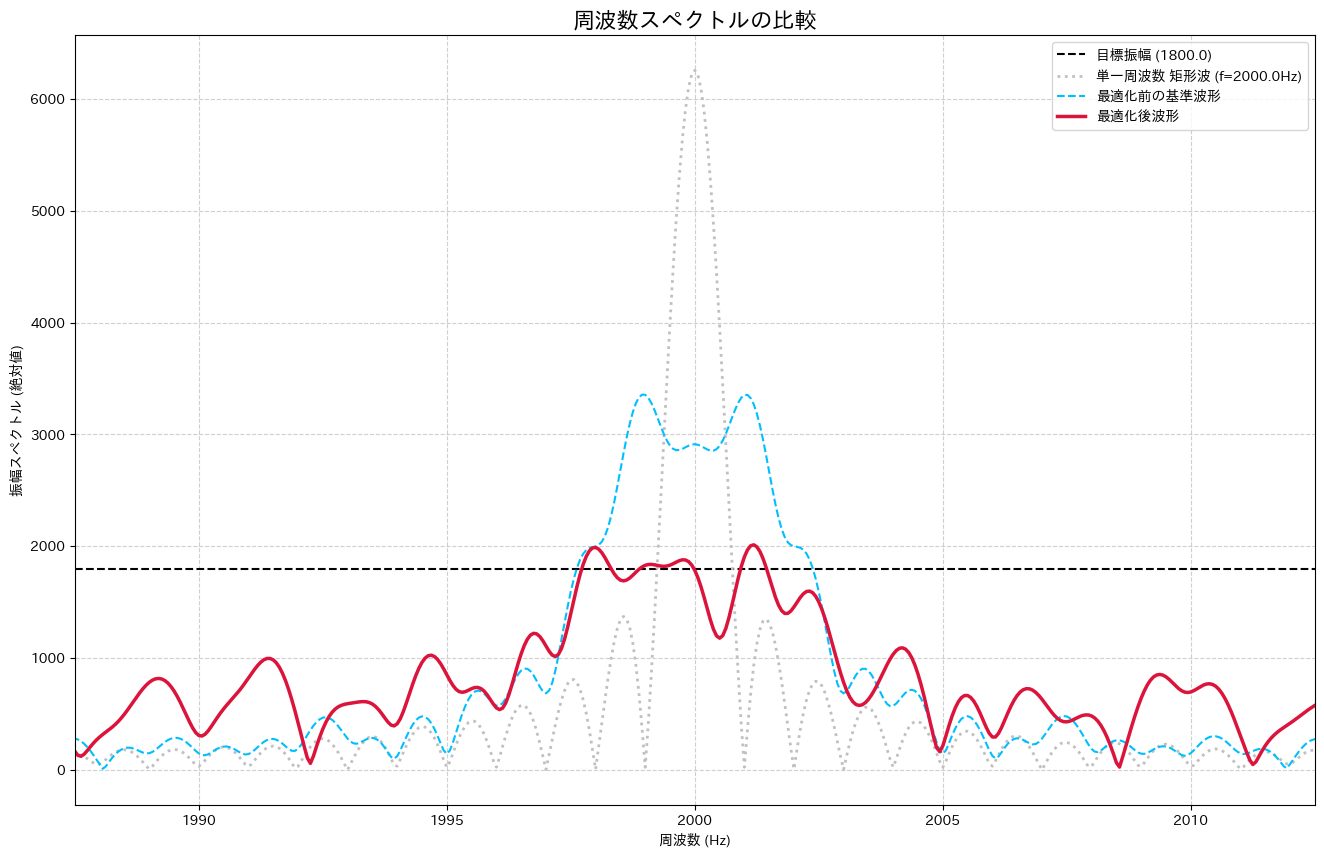

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語フォントの設定
from scipy.signal import czt
import time
import random

# ==============================================================================
# --- 1. 設計仕様とパラメータ設定 ---
# ==============================================================================
# --- 物理仕様 ---
fs = 10000  # サンプリング周波数 (Hz)
L = 1.0     # 信号長 (s)
A = 1.0     # 振幅

# --- 周波数仕様 ---
f_start = 1997.5  # チャープ開始周波数 (Hz)
f_end = 2002.5    # チャープ終了周波数 (Hz)
f_c = (f_start + f_end) / 2  # 比較用の中心周波数 (Hz)

# --- チャープ率計算設定 ---
RECALCULATE_CHIRP_RATE = False      # Trueにすると再計算する（時間がかかる）
PRECALCULATED_CHIRP_RATE = 0.0025   # 事前に計算したチャープ率

# --- 最適化パラメータ ---
target_amplitude = 1800.0  # 最適化の目標振幅
n_iterations_sa = 10000    # 焼きなまし法の反復回数 (必要に応じて増減)
initial_temp = 100.0       # 初期温度
cooling_rate = 0.999       # 冷却率


# ==============================================================================
# --- 2. 時間軸とFFT設定 ---
# ==============================================================================
n_samples = int(L * fs)
t = np.linspace(0, L, n_samples, endpoint=False)
n_fft = n_samples * 16  # FFTの解像度
freq = np.fft.fftfreq(n_fft, d=1 / fs)
freq_shifted = np.fft.fftshift(freq)


# ==============================================================================
# --- 3. 各種関数の定義 ---
# ==============================================================================
def calculate_optimal_chirp_rate(f_start_calc, f_end_calc, L_calc):
    """
    設計仕様（f_start, f_end, L）を満たす最適なチャープ率を二分探索で計算する。
    """
    print("設計仕様を満たすチャープ率を計算中... (時間がかかります)")
    w_start_calc = 1.0 / (2.0 * f_start_calc)
    w_end_calc = 1.0 / (2.0 * f_end_calc)
    low_cr, high_cr = 0.0, 10000.0  # 探索範囲

    for _ in range(100):  # 二分探索 (100回で十分な精度)
        mid_cr = (low_cr + high_cr) / 2
        if mid_cr <= 1e-9:
            low_cr = 1e-9
            continue

        time_acc, domain_idx = 0.0, 0
        while time_acc < L_calc:
            width = w_start_calc / \
                np.sqrt(1 + 2 * mid_cr * w_start_calc * domain_idx)
            time_acc += width
            domain_idx += 1

        final_width = w_start_calc / \
            np.sqrt(1 + 2 * mid_cr * w_start_calc * (domain_idx - 1))

        if final_width < w_end_calc:
            high_cr = mid_cr
        else:
            low_cr = mid_cr

    best_rate = (low_cr + high_cr) / 2
    print(f"計算された最適なチャープ率: {best_rate:.4f}")
    return best_rate


# ==============================================================================
# --- 4. 各種波形の生成 ---
# ==============================================================================

# --- 4.1. 仕様を満たす基準チャープ波形の生成 ---
# フラグに応じてチャープ率を決定
if RECALCULATE_CHIRP_RATE:
    best_chirp_rate = calculate_optimal_chirp_rate(f_start, f_end, L)
else:
    best_chirp_rate = PRECALCULATED_CHIRP_RATE
    print(f"事前計算されたチャープ率を使用: {best_chirp_rate:.4f}")

print("最終的な基準チャープ波形を生成中...")
s_t_base_chirp = np.zeros(n_samples)
domains = []
current_time, domain_idx, sign, last_sample_idx = 0.0, 0, 1, 0
w_start_gen = 1.0 / (2.0 * f_start)

while last_sample_idx < n_samples:
    width = w_start_gen / \
        np.sqrt(1 + 2 * best_chirp_rate * w_start_gen * domain_idx)

    start_sample_idx = last_sample_idx
    end_sample_idx = int((current_time + width) * fs)
    if end_sample_idx > n_samples:
        end_sample_idx = n_samples

    s_t_base_chirp[start_sample_idx:end_sample_idx] = sign * A
    if start_sample_idx < end_sample_idx:
        domains.append((start_sample_idx, end_sample_idx))

    current_time += width
    domain_idx += 1
    sign *= -1
    last_sample_idx = end_sample_idx

print(f"生成されたドメイン数: {len(domains)}")

# --- 4.2. 比較用の単一周波数（一定周期）波形の生成 ---
print("比較用の単一周波数（一定周期）波形を生成中...")
s_t_const_freq = A * np.sign(np.sin(2 * np.pi * f_c * t))


# ==============================================================================
# --- 5. 最適化アルゴリズム (ドメイン区間反転版) ---
# ==============================================================================
def optimize_sa_domain_segment_flip(initial_signal, domains_list, n_iterations, temp, cool_rate, target_amp):
    """焼きなまし法で波形を最適化（ドメインの "区間" をまとめて反転）"""
    print(f"\n焼きなまし法（ドメイン区間反転版）による最適化中...")

    current_signal = initial_signal.copy()

    # Zoom FFTのパラメータ設定
    m_zoom = int((f_end - f_start) / (fs / n_fft))
    if m_zoom == 0:
        m_zoom = 1
    w = np.exp(-1j * 2 * np.pi * (f_end - f_start) / (m_zoom * fs))
    a = np.exp(1j * 2 * np.pi * f_start / fs)

    def calculate_cost(spectrum): return np.sum((spectrum - target_amp)**2)

    current_spectrum = np.abs(czt(current_signal, m=m_zoom, w=w, a=a))
    current_cost = calculate_cost(current_spectrum)

    best_signal, best_cost = current_signal, current_cost
    n_domains = len(domains_list)

    if n_domains < 2:
        print("ドメイン数が2未満のため、最適化を実行できません。")
        return initial_signal

    for i in range(n_iterations):
        neighbor_signal = current_signal.copy()
        start_domain_idx = random.randint(0, n_domains - 2)
        end_domain_idx = random.randint(start_domain_idx + 1, n_domains - 1)
        for domain_idx in range(start_domain_idx, end_domain_idx + 1):
            start_sample, end_sample = domains_list[domain_idx]
            neighbor_signal[start_sample:end_sample] *= -1

        neighbor_spectrum = np.abs(czt(neighbor_signal, m=m_zoom, w=w, a=a))
        neighbor_cost = calculate_cost(neighbor_spectrum)

        cost_diff = neighbor_cost - current_cost
        if cost_diff < 0 or random.random() < np.exp(-cost_diff / temp):
            current_signal, current_cost = neighbor_signal, neighbor_cost

        if current_cost < best_cost:
            best_signal, best_cost = current_signal, current_cost

        temp *= cool_rate
        if (i + 1) % 1000 == 0:
            print(
                f"  Iteration {i+1}/{n_iterations}: Cost = {best_cost:.4g}, Temp = {temp:.4g}")

    print("最適化完了。")
    return best_signal


# ==============================================================================
# --- 6. 最適化の実行 ---
# ==============================================================================
s_t_sa_optimized = optimize_sa_domain_segment_flip(
    s_t_base_chirp, domains, n_iterations_sa, initial_temp, cooling_rate, target_amplitude
)


# ==============================================================================
# --- 7. 結果のプロット ---
# ==============================================================================
# --- 7.1. 時間領域プロット ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('時間領域波形の比較', fontsize=16)

axes[0].plot(t, s_t_const_freq, drawstyle='steps-post', color='deepskyblue')
axes[0].set_title(f'比較用：単一周波数 矩形波 (f={f_c}Hz)')
axes[0].set_ylabel('振幅')
axes[0].set_xlim(0, 0.05)

axes[1].plot(t, s_t_base_chirp, drawstyle='steps-post', color='gray')
axes[1].set_title(f'最適化前の基準波形 (Chirp Rate: {best_chirp_rate:.4f})')
axes[1].set_ylabel('振幅')
axes[1].set_xlim(0, 0.05)

axes[2].plot(t, s_t_sa_optimized, drawstyle='steps-post', color='crimson')
axes[2].set_title('焼きなまし法による最適化後波形')
axes[2].set_xlabel('時間 (s)')
axes[2].set_ylabel('振幅')
axes[2].set_xlim(0, 0.05)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 7.2. 周波数スペクトルプロット ---
plt.figure(figsize=(16, 10))
spectra = {
    'const_freq': np.fft.fft(s_t_const_freq, n=n_fft),
    'base_chirp': np.fft.fft(s_t_base_chirp, n=n_fft),
    'sa_optimized': np.fft.fft(s_t_sa_optimized, n=n_fft)
}


def plot_spectrum_absolute(S_f, label, **kwargs):
    plt.plot(freq_shifted, np.abs(np.fft.fftshift(S_f)), label=label, **kwargs)


plt.axhline(y=target_amplitude, color='black', linestyle='--',
            label=f'目標振幅 ({target_amplitude})')

plot_spectrum_absolute(
    spectra['const_freq'], f'単一周波数 矩形波 (f={f_c}Hz)', color='silver', linewidth=2.0, linestyle=':')
plot_spectrum_absolute(spectra['base_chirp'], '最適化前の基準波形',
                       color='deepskyblue', linewidth=1.5, linestyle='--')
plot_spectrum_absolute(spectra['sa_optimized'],
                       '最適化後波形', color='crimson', linewidth=2.5)

plt.title('周波数スペクトルの比較', fontsize=16)
plt.xlabel('周波数 (Hz)')
plt.ylabel('振幅スペクトル (絶対値)')
plt.xlim(f_start - (f_end-f_start)*2, f_end + (f_end-f_start)*2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()